# Marco Esparza, Final Project

In [1]:
# matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt

# NumPy
import numpy as np
from numpy import pi, sin, cos, sqrt, cbrt, arccos, fft
from numpy.random import default_rng
import numpy.polynomial.legendre as legendre

# SciPy
import scipy
import scipy.linalg as linalg
import scipy.interpolate as interpolate
import scipy.integrate as integrate
import scipy.optimize as opt

In [2]:
## Useful functions

def magnitude3D(x, y, z):
    return np.sqrt(x**2 + y**2 + z**2)

def almostEqual(a, b, error):
    if abs(b - a) <= error:
        return True
    else:
        return False
    
def forwDiff_1D(f, x, h):        # Forward Difference in 1D
    return ( f(x+h) - f(x) ) / h

def backDiff_1D(f, x, h):
    return (f(x) - f(x-h)) / h

def CD_deriv_1D(f, x, h):   # Central Difference of a known function in 1D
    return (f(x+h) - f(x-h)) / h

def partialXDer(f, x, y, h):
    return ( f(x + h/2, y) - f(x - h/2, y) ) / h

def partialYDer(f, x, y, h):
    return ( f(x, y + h/2) - f(x, y - h/2) ) / h

def magn(x, y):
    return np.sqrt(x**2 + y**2)

def magnSq(x, y):
    return x**2 + 3*y**2

def testJacobian(x, y):
    return 7*x + 5*y

def Jacobian2D(f1, f2, x, y, h):
    J = np.zeros((2, 2))      # The Jacobian Matrix
    J[0, 0], J[0, 1] = partialXDer(f1, x, y, h), partialYDer(f1, x, y, h)
    J[1, 0], J[1, 1] = partialXDer(f2, x, y, h), partialYDer(f2, x, y, h)
    det = J[0, 0]*J[1, 1] - J[0, 1]*J[1, 0]
    return J, det         # The Jacobian matrix & its determinant


def partialPivot(A, b):
    N = len(A)
    for m in range(N):
        diagElem = A[m, m]          # Get the diagonal element
        topRow = np.copy(A[m])
        topbElem = float(b[m])
        for i in range(m+1, N):
            currRow = np.copy(A[i])
            currB = float(b[i])
            elemBelow = A[i, m]         # All the elements below divided
                                        # by the respective diagonal element
            if abs(diagElem) < abs(elemBelow):
                A[m], A[i] =  currRow, topRow # Swap the rows
                b[m], b[i] = currB, topbElem
                break
    return A, b


def gaussElim(startA, startB):   # From HW5
    N = len(startB)
    A, b = partialPivot(startA, startB)

    # Gaussian elimination
    for m in range(N):

        # Divide by the diagonal element
        div = A[m,m]
        A[m,:] /= div
        b[m] /= div

        # Now subtract from the lower rows
        for i in range(m+1,N):
            mult = A[i,m]
            A[i,:] -= mult*A[m,:]
            b[i] -= mult*b[m]

    # Backsubstitution
    x = np.empty(N,float)
    for m in range(N-1,-1,-1):
        x[m] = b[m]
        for i in range(m+1,N):
            x[m] -= A[m,i]*x[i]
    return x






## Initial Conditions

Text(0, 0.5, 'y')

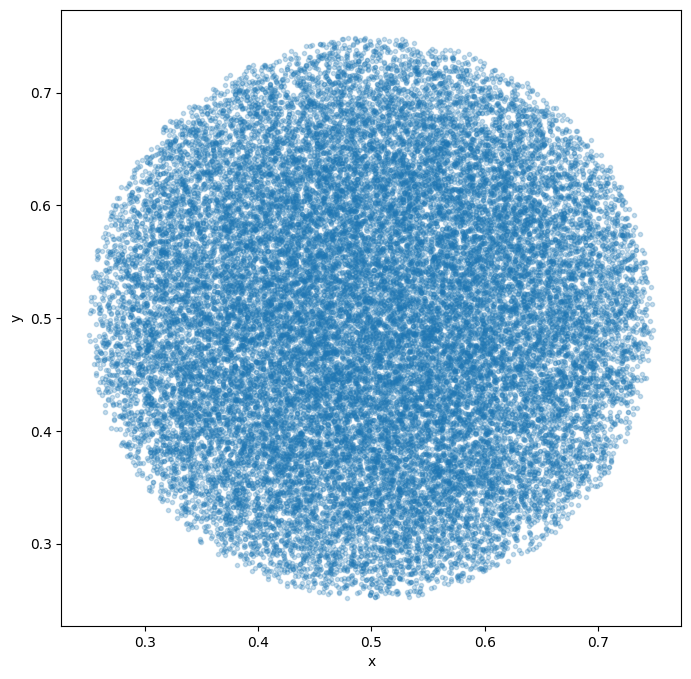

In [3]:
L = 1           # Length in m
Rs = L / 4      # Radius of Sphere
Np = 32**3      # Number of particles
mp = 1          # Fixed mass of particles in kg
epsilon = 1e-10  # Threshold value
G = 1    # Newton's Gravitational Constant in N m^2 / kg^2


empty = np.empty((9, Np))  # Describes each particle's motion, 
# by storing a given particle's x, y, z, and respective v & a components
# in rows, (so all the x-comps are in one row, followed by the y row, etc)



def rDist(q): # Let q be our uniform deviate
    return cbrt(3*q)

def thetaDist(q):
    return arccos(1 - q)

def generatePoint():
    rng = default_rng()
    r = rDist(rng.random() * (1/3*Rs **3))
    theta = thetaDist(rng.random() * 2)
    phi = rng.random() * 2*pi
    x = r*sin(theta)*cos(phi) + L/2 # Center at (L/2, L/2, L/2)
    y = r*sin(theta)*sin(phi) + L/2
    z = r*cos(theta) + L/2
    return np.array([x, y, z])

def generateSystem(pArray):
    for i in range(Np):
        pos = generatePoint()
        x, y, z = pos[0], pos[1], pos[2]
        pArray[0][i] = x
        pArray[1][i] = y
        pArray[2][i] = z
    return pArray

prtMotion = generateSystem(empty)

xArray = prtMotion[0]
yArray = prtMotion[1]
zArray = prtMotion[2]

plt.figure(figsize=(8, 8))
plt.plot(xArray, yArray, linestyle="None", marker=".", alpha=0.25)
plt.xlabel("x")
plt.ylabel("y") 




## Suggestions for functions:
#   density, potential, force, accelaratio
#   accelaration function derived from interpolation of force 
#   Verlet function to integrate particles over time, and use KDK or DKD for one time step




Text(0, 0.5, 'z')

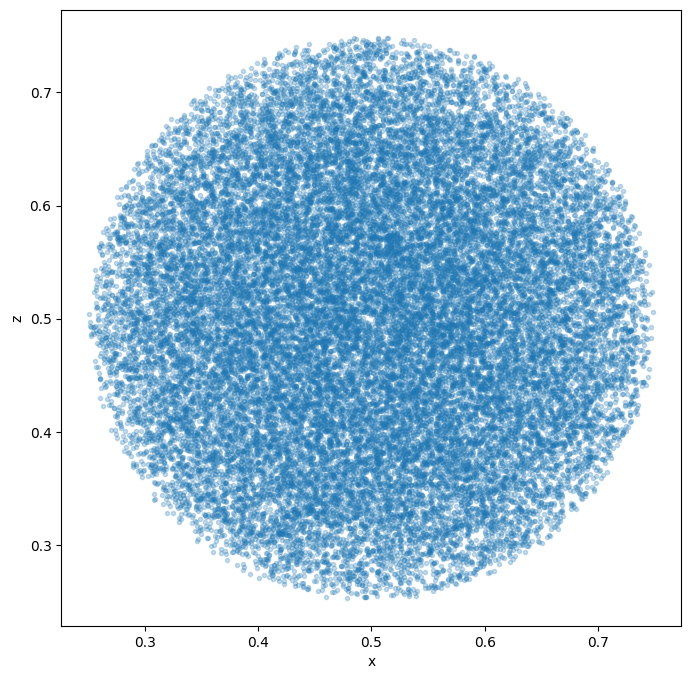

In [4]:
plt.figure(figsize=(8, 8))
plt.plot(xArray, zArray, linestyle="None", marker=".", alpha=0.25)
plt.xlabel("x")
plt.ylabel("z")

## Density Field

In [5]:
Nc = 128
l = L / Nc
Ld = np.arange(0, 1, l)  # domain length


def Delta_m(i, j, k, DeltaX, DeltaY, DeltaZ):
    outOfBox = (i < 0) or (j < 0) or (k < 0) or (i >= Nc) or (j >= Nc) or (k >= Nc)
    if outOfBox:
        return 0
    else:
        return mp*DeltaX*DeltaY*DeltaZ / l**3
    

def createRho(prt):
    rho = np.zeros((Nc, Nc, Nc), float)
    gridPoints = np.arange(Nc)*l
    for p in range(Np):   # comp = component, prt = array of particles,  p = particle
        px, py, pz = prt[0][p], prt[1][p], prt[2][p]
        pp = np.array([px, py, pz])
        pp = np.nan_to_num(pp, 200)
        px, py, pz = pp[0], pp[1], pp[2]

        pxLo, pxHi = px - l/2, px + l/2
        pyLo, pyHi = py - l/2, py + l/2
        pzLo, pzHi = pz - l/2, pz + l/2


        # multiply by 128 to recover nearest index less than particle boundary
            # (i.e. find the box each index "falls" in)
        if pxLo == np.nan or pxHi == np.nan:
            k1, k2 = -2, Nc + 1         # send outside the domain
        else:
            k1, k2 = int(pxLo*Nc), int(pxHi*Nc)

        if pyLo == np.nan or pyHi == np.nan:
            j1, j2 = -2, Nc + 1         # send outside the domain
        else: 
            j1, j2 = int(pyLo*Nc), int(pyHi*Nc)

        if pzLo == np.nan or pzHi == np.nan:
            i1, i2 = -2, Nc + 1
        else:
            i1, i2 = int(pzLo*Nc), int(pzHi*Nc)

        # Find grid points
        x1, x2 = np.float16(k1) / Nc, np.float16(k2) / Nc
        y1, y2 = np.float16(j1) / Nc, np.float16(j2) / Nc
        z1, z2 = np.float64(i1) / Nc, np.float64(i2) / Nc

        # Find Δr_1, where r = x, y, z
        Delta_x1, Delta_x2 = x2 - pxLo, pxHi - x2 
        Delta_y1, Delta_y2 = y2 - pyLo, pyHi - y2
        Delta_z1, Delta_z2 = z2 - pzLo, pzHi - z2
        
        
        # Add Δm to 8 possibly overlapping cells
        i_1, i_2 = i1 % Nc, i2 % Nc  # mod used to avoid pre-runtime indexing errors
        j_1, j_2 = j1 % Nc, j2 % Nc
        k_1, k_2 = k1 % Nc, k2 % Nc


        rho[i_1, j_1, k_1] += Delta_m(i1, j1, k1, Delta_x1, Delta_y1, Delta_z1)
        rho[i_1, j_1, k_2] += Delta_m(i1, j1, k2, Delta_x2, Delta_y1, Delta_z1)
        rho[i_1, j_2, k_1] += Delta_m(i1, j2, k1, Delta_x1, Delta_y2, Delta_z1)
        rho[i_1, j_2, k_2] += Delta_m(i1, j2, k2, Delta_x2, Delta_y2, Delta_z1)
        rho[i_2, j_1, k_1] += Delta_m(i2, j1, k1, Delta_x1, Delta_y1, Delta_z2)
        rho[i_2, j_1, k_2] += Delta_m(i2, j1, k2, Delta_x2, Delta_y1, Delta_z2)
        rho[i_2, j_2, k_1] += Delta_m(i2, j2, k1, Delta_x1, Delta_y2, Delta_z2)
        rho[i_2, j_2, k_2] += Delta_m(i2, j2, k2, Delta_x2, Delta_y2, Delta_z2)
    return (rho)

rho = createRho(prtMotion)
# print(rho)

massCheck = (np.sum(rho)) *L**3
print(massCheck)

 

32768.00000000001


## Poisson Solver

<>:77: SyntaxWarning: invalid escape sequence '\P'
<>:77: SyntaxWarning: invalid escape sequence '\P'
C:\Users\marco\AppData\Local\Temp\ipykernel_255608\2240357443.py:77: SyntaxWarning: invalid escape sequence '\P'
  plt.title(f"$\Phi$(x, y, z={z})")


Text(0, 0.5, 'y')

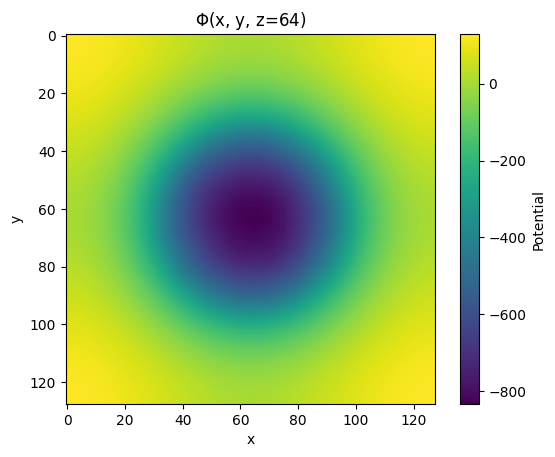

In [47]:
Nk = Nc


def krValues(Nk):      # e.g. kr_i values along r_i-direction, r_i = x, y, z
    kx = np.zeros(Nk)
    for k in range(Nk//2 + 1):
        kx[k] = 2*pi*k / Nk
        if k < Nk//2 and k > 0:
            kx[k + Nk//2] = 2*pi*(k + Nk//2 - Nk) / Nk
    return kx


def w(k):
    kx, ky, kz = k[0], k[1], k[2]
    num = 4*pi*G
    denom = (2*sin(kx/2))**2 + (2*sin(ky/2))**2 + (2*sin(kz/2))**2
    if almostEqual(denom, 0, 1e-10) :
        return 0
    else:
        return -num/denom


def kernel(w, kr):
    wk = np.zeros((Nk, Nk, Nk//2+1), float)
    for i in range(Nk):
        for j in range(Nk):
            for k in range(Nk//2 + 1):

                kx, ky, kz = kr[k], kr[j], kr[i]
                kVec = np.array([kx, ky, kz])
                wk[i, j, k] = w(kVec)
    return wk

def finish_irfft(gVals, Nk): # incomplete 1D iFFT Array
    for k in range((Nk-1)//2, 0, -1):
        g = gVals[k]
        gVals = np.append(gVals, np.conjugate(g))
    return gVals


def create_kr(N, ik):  # k-index value
    if ik <= N // 2:
        kr = 2*pi/Nk * ik
    else:
        kr = 2*pi/Nk * (ik - Nk)

def create_Rhok(real_fn):
    init_rho_k = fft.rfftn(rho) 
    rho_k = np.zeros((Nk, Nk, Nk), complex)
    for ik in range(Nk):
        for jk in range(Nk):
            for kk in range(Nk//2 - 1):  # Nk = 1/2 is left out, 
                kz, ky, kx = create_kr(Nk, ik), create_kr(Nk, jk), create_kr(Nk, kk)
                
                val = init_rho_k[ik, jk, kk]
                rho_k[ik, jk, kk] = val
                rho_k[ik, jk,-kk] = np.conjugate(val)
    return rho_k


def createPhi(rho_k, wk):
    Phi_k = rho_k*wk
    Phi = fft.irfftn(Phi_k)
    return Phi


krArray = krValues(Nk)
wk = kernel(w, krArray)
rho_k = fft.rfftn(rho)
correct_rhok = fft.fftn(rho)
Phi = createPhi(rho_k, wk)


z = Nk//2
slicee = Phi[z]
plt.imshow(slicee)
plt.title(f"$\Phi$(x, y, z={z})")
plt.colorbar().set_label("Potential")
plt.xlabel("x")
plt.ylabel("y")

## Force Per Unit mass

In [ ]:

def partialxPoint(array, i, j, k, h): # partial Finite Difference Derivative
    N = len(array)
    if k == 0:                    
        partialx = (array[i,j,k + 1] - array[i,j,k]) / h    # partial  with respect to x
    elif 1 <= k <= N - 2:
        partialx = (array[i,j,k+1] - array[i,j,k-1]) / (2*h)
    elif k == N-1:
        partialx = (array[i,j,k] - array[i,j,k-1]) / h
    return partialx

def partialyPoint(array, i, j, k, h):   # partial Finite Difference Derivative 
    N = len(array)
    if j == 0:                  
        partialy = (array[i,j+1,k] - array[i,j,k]) / h   # partial  with respect to y
    elif 1 <= j <= N - 2:
        partialy = (array[i,j+1,k] - array[i,j-1,k]) / (2*h)
    elif j == N-1:
        partialy = (array[i,j,k] - array[i,j-1,k]) / h
    return partialy

def partialzPoint(array, i, j, k, h): # partial Finite Difference Derivative
    N = len(array)
    if i == 0:
        partialz = (array[i+1,j,k] - array[i,j,k]) / h # partial  with respect to x
    elif 1 <= i <= N - 2:
        partialz = (array[i+1,j,k] - array[i-1,j,k]) / (2*h)
    elif i == N-1:
        partialz = (array[i,j,k] - array[i-1,j,k]) / h
    return partialz


def grad(scalarArr, h):   
    gradArray = np.zeros((Nc, Nc, Nc, 3), float)
    for i in range(Nc):
        for j in range(Nc):
            for k in range(Nc):
                gradArray[i, j, k, 0] = partialxPoint(scalarArr, i, j, k, h)
                gradArray[i, j, k, 1] = partialyPoint(scalarArr, i, j, k, h)
                gradArray[i, j, k, 2] = partialzPoint(scalarArr, i, j, k, h)
    return gradArray

def forcePerMass(PhiFunc):
    return -grad(PhiFunc, l)

fPM = forcePerMass(Phi)




## Debugging, Part 1

k1 = 63, k2 = 64, j1 = 63, j2 = 64, i1 = 63, i2 = 64
ρ[63, 63, 63] = 0.09941218560000264
ρ[63, 63, 64] = 0.11300701440000141
ρ[63, 64, 63] = 0.10463581440000219
ρ[63, 64, 64] = 0.1189449856000008
ρ[64, 63, 63] = 0.12859741439999972
ρ[64, 63, 64] = 0.14618338559999763
ρ[64, 64, 63] = 0.13535458559999897
ρ[64, 64, 64] = 0.15386461439999663
1.0


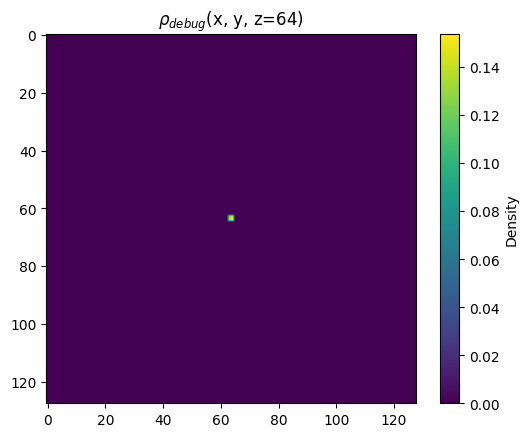

In [48]:
debug_Np = 1
alpha, beta, gamma = 0.50025, 0.5001, 0.5005

debugPrt = np.array([[alpha], [beta], [gamma], [0], [0], [0], [0], [0], [0]])

def debugCreateRho(prt):
    rho = np.zeros((Nc, Nc, Nc), float)
    gridPoints = np.arange(Nc)*l
    for p in range(debug_Np):   # comp = component, prt = array of particles,  p = particle
        px, py, pz = prt[0][p], prt[1][p], prt[2][p]
        pxLo, pxHi = px - l/2, px + l/2
        pyLo, pyHi = py - l/2, py + l/2
        pzLo, pzHi = pz - l/2, pz + l/2

        # multiply by 128 to recover nearest index less than particle boundary
            # (i.e. find the box each index "falls" in)
        k1, k2 = int(pxLo*Nc), int(pxHi*Nc)
        j1, j2 = int(pyLo*Nc), int(pyHi*Nc)
        i1, i2 = int(pzLo*Nc), int(pzHi*Nc)

        # Find grid points
        x1, x2 = np.float16(k1) / Nc, np.float16(k2) / Nc
        y1, y2 = np.float16(j1) / Nc, np.float16(j2) / Nc
        z1, z2 = np.float16(i1) / Nc, np.float16(i2) / Nc

        # Find Δr_1, where r = x, y, z
        Delta_x1, Delta_x2 = x2 - pxLo, pxHi - x2 
        Delta_y1, Delta_y2 = y2 - pyLo, pyHi - y2
        Delta_z1, Delta_z2 = z2 - pzLo, pzHi - z2
        
        # Add Δm to 8 possibly overlapping cells
        rho[i1, j1, k1] += Delta_m(i1, j1, k1, Delta_x1, Delta_y1, Delta_z1)
        rho[i1, j1, k2] += Delta_m(i1, j1, k2, Delta_x2, Delta_y1, Delta_z1)
        rho[i1, j2, k1] += Delta_m(i1, j2, k1, Delta_x1, Delta_y2, Delta_z1)
        rho[i1, j2, k2] += Delta_m(i1, j2, k2, Delta_x2, Delta_y2, Delta_z1)
        rho[i2, j1, k1] += Delta_m(i2, j1, k1, Delta_x1, Delta_y1, Delta_z2)
        rho[i2, j1, k2] += Delta_m(i2, j1, k2, Delta_x2, Delta_y1, Delta_z2)
        rho[i2, j2, k1] += Delta_m(i2, j2, k1, Delta_x1, Delta_y2, Delta_z2)
        rho[i2, j2, k2] += Delta_m(i2, j2, k2, Delta_x2, Delta_y2, Delta_z2)

        print(f"k1 = {k1}, k2 = {k2}, j1 = {j1}, j2 = {j2}, i1 = {i1}, i2 = {i2}")
    print(f"ρ[{i1}, {j1}, {k1}] = {rho[i1, j1, k1]}")
    print(f"ρ[{i1}, {j1}, {k2}] = {rho[i1, j1, k2]}")
    print(f"ρ[{i1}, {j2}, {k1}] = {rho[i1, j2, k1]}")
    print(f"ρ[{i1}, {j2}, {k2}] = {rho[i1, j2, k2]}")
    print(f"ρ[{i2}, {j1}, {k1}] = {rho[i2, j1, k1]}")
    print(f"ρ[{i2}, {j1}, {k2}] = {rho[i2, j1, k2]}")
    print(f"ρ[{i2}, {j2}, {k1}] = {rho[i2, j2, k1]}")
    print(f"ρ[{i2}, {j2}, {k2}] = {rho[i2, j2, k2]}")
    return rho



debug_rho = debugCreateRho(debugPrt)
debug_massCheck = (np.sum(debug_rho)) *L**3
print(debug_massCheck)

zz = Nc // 2
plt.imshow(debug_rho[zz])
plt.title(r"$\rho_{debug}$(x, y, z=" + f"{zz}" + ")")
plt.colorbar().set_label("Density")

Text(0, 0.5, 'y')

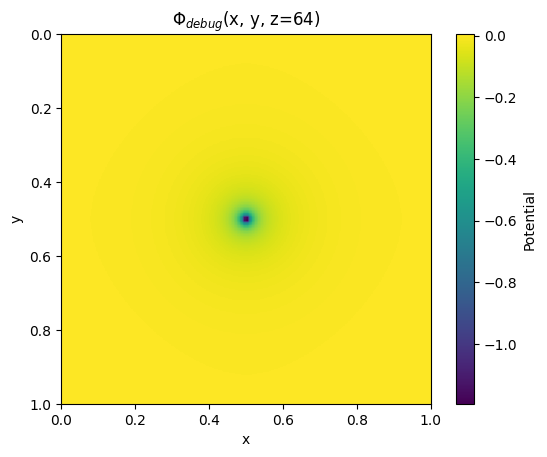

In [49]:
debug_krArray = krValues(Nk)
debug_wk = kernel(w, debug_krArray)
debug_rho_k = fft.rfftn(debug_rho)
debug_Phi = createPhi(debug_rho_k,debug_wk)


zSlice = debug_Phi[zz]
plt.imshow(zSlice, extent=[0, L, L, 0])
plt.title(r"$\Phi_{debug}$(x, y, z=" + f"{zz}" + ")")
plt.colorbar().set_label("Potential")
plt.xlabel("x")
plt.ylabel("y")

## Debugging, Part 2

f(0.709622224430894) = 0.002109572453272791


Text(0, 0.5, 'f(r)')

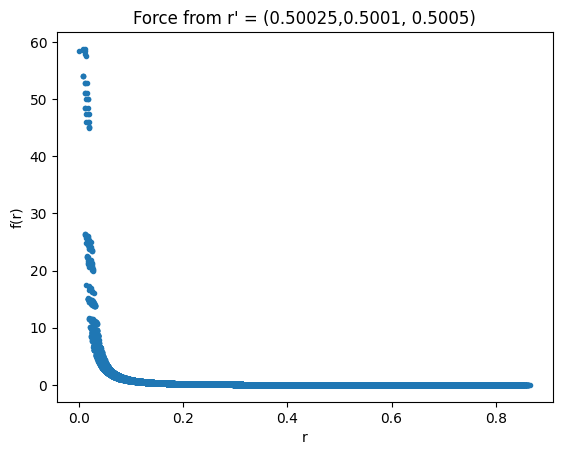

In [10]:

def get_fr(f, alpha, beta, gamma):    # Get function f(r), with center x, y, z
    rArray = np.zeros(Nc**3, float)
    frArray = np.zeros(Nc**3, float)
    q = 0
    for i in range(Nc):
        for j in range(Nc):
            for k in range(Nc):
                z, y, x = i*l, j*l, k*l
                rFromCenter = magnitude3D(x-alpha, y-beta, z-gamma)   # Place r at center
                fx = f[i, j, k, 0]
                fy = f[i, j, k, 1]
                fz = f[i, j, k, 2]
                fr = magnitude3D(fx, fy, fz)
                rArray[q] = rFromCenter
                frArray[q] = fr
                q += 1
    return np.array(rArray), np.array(frArray)


debug_fPM = forcePerMass(debug_Phi)
debug_r, debug_fr = get_fr(debug_fPM, alpha, beta, gamma)
print(f"f({debug_r[Nc//2 + 7]}) = {debug_fr[Nc//2+7]}")

plt.plot(debug_r, debug_fr, marker=".", linestyle="None")
plt.title(f"Force from r' = ({alpha},{beta}, {gamma})")
plt.xlabel("r")
plt.ylabel("f(r)")

## Accelaration Profile

f(0.815499271918743) = 99.02557566205809


Text(0, 0.5, 'f(r)')

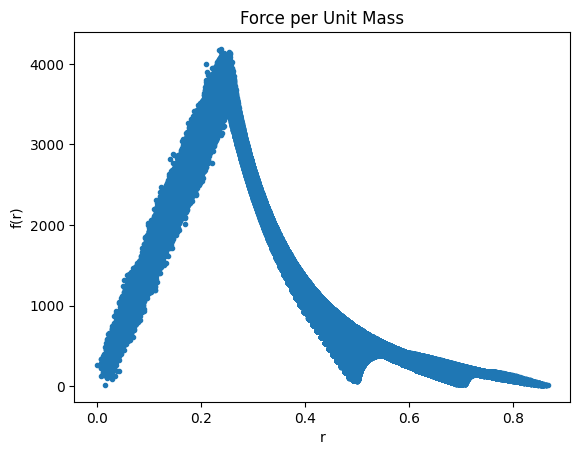

In [11]:
rVals, frVals = get_fr(fPM, L/2, L/2, L/2)
print(f"f({rVals[12]}) = {frVals[12]}")


plt.plot(rVals, frVals, marker=".", linestyle="None")
plt.title("Force per Unit Mass")
plt.xlabel("r")
plt.ylabel("f(r)")


## Enclosed Mass Profile

In [45]:

def enclMass(rho):
    rValues = np.zeros(Nk//2, float)
    massEncl = np.zeros(Nk//2, float)
    #print(massEncl456)
    mass = 0
    for i in range(Nk // 2):
        if i == 0:
            mass += rho[Nk//2 - i, Nk//2 - i, Nk//2 - i]*(l**3)  # l**3 Volume element
        else:
            mass += rho[Nk//2 - i, Nk//2 - i, Nk//2 - i]*(l**3)*(i**2 - (i-1)**2)
        r = magnitude3D(i*l, i*l, i*l)
        rValues[i] = r
        massEncl[i] = mass
    return rVals, massEncl

## [Unsuccessful]




[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


## Interpolate Accelarations

In [12]:


def accWeight(i, j, k, DeltaX, DeltaY, DeltaZ):
    outOfBox = (i < 0) or (j < 0) or (k < 0) or (i >= Nc) or (j >= Nc) or (k >= Nc)
    if outOfBox:
        return 0
    else:
        return DeltaX*DeltaY*DeltaZ / l**3
    

def interpAcc(prt, fpm):
    for p in range(Np):   # comp = component, prt = array of particles,  p = particle
        px, py, pz = prt[0, p], prt[1, p], prt[2, p]
        pxLo, pxHi = px - l/2, px + l/2
        pyLo, pyHi = py - l/2, py + l/2
        pzLo, pzHi = pz - l/2, pz + l/2

        # multiply by 128 to recover nearest index less than particle boundary
            # (i.e. find the box each index "falls" in)
        k1, k2 = int(pxLo*Nc), int(pxHi*Nc)
        j1, j2 = int(pyLo*Nc), int(pyHi*Nc)
        i1, i2 = int(pzLo*Nc), int(pzHi*Nc)

        # Find grid points
        x1, x2 = np.float16(k1) / Nc, np.float16(k2) / Nc
        y1, y2 = np.float16(j1) / Nc, np.float16(j2) / Nc
        z1, z2 = np.float64(i1) / Nc, np.float64(i2) / Nc

        # Find Δr_1, where r = x, y, z
        Delta_x1, Delta_x2 = x2 - pxLo, pxHi - x2 
        Delta_y1, Delta_y2 = y2 - pyLo, pyHi - y2
        Delta_z1, Delta_z2 = z2 - pzLo, pzHi - z2
        
        # Add Δm to 8 possibly overlapping cells
        i_1, i_2 = i1 % Nc, i2 % Nc  # mod used to avoid pre-runtime indexing errors
        j_1, j_2 = j1 % Nc, j2 % Nc
        k_1, k_2 = k1 % Nc, k2 % Nc
        aVec = np.zeros(3, float)
        for rr in range(3):
            aComp = 0
            aComp += fpm[i_1, j_1, k_1, rr]*accWeight(i1, j1, k1, Delta_x1, Delta_y1, Delta_z1)
            aComp += fpm[i_1, j_1, k_2, rr]*accWeight(i1, j1, k2, Delta_x2, Delta_y1, Delta_z1)
            aComp += fpm[i_1, j_2, k_1, rr]*accWeight(i1, j2, k1, Delta_x1, Delta_y2, Delta_z1)
            aComp += fpm[i_1, j_2, k_2, rr]*accWeight(i1, j2, k2, Delta_x2, Delta_y2, Delta_z1)
            aComp += fpm[i_2, j_1, k_1, rr]*accWeight(i2, j1, k1, Delta_x1, Delta_y1, Delta_z2)
            aComp += fpm[i_2, j_1, k_2, rr]*accWeight(i2, j1, k2, Delta_x2, Delta_y1, Delta_z2)
            aComp += fpm[i_2, j_2, k_1, rr]*accWeight(i2, j2, k1, Delta_x1, Delta_y2, Delta_z2)
            aComp += fpm[i_2, j_2, k_2, rr]*accWeight(i2, j2, k2, Delta_x2, Delta_y2, Delta_z2)
            aVec[rr] = aComp
        prt[6, p] = aVec[0]
        prt[7, p] = aVec[1]
        prt[8, p] = aVec[2]
    return prt


prtMotion = interpAcc(prtMotion, fPM)







## Time Evolution

C:\Users\marco\AppData\Local\Temp\ipykernel_255608\809028948.py:75: RuntimeWarning: divide by zero encountered in scalar divide
  dt = lmbda*np.min([l/vMax, np.sqrt(l/aMax)])


9
0.0
0.6383635629998248
1.2750422962016055
1.906082039555737
2.528852561669071
3.141980987549717
3.6400569883592415
4.064180804042417
4.4389539826980675
4.778185014473044
5.089584681368028
5.3781812865735485
5.647960660530203
5.901355599952548
6.140477107038133
6.367286010272502
6.583220160045972
6.789456717241939
6.986980506849966
7.176728711484015
7.35925954539876
7.534434223305215
7.7027024601841925
7.864563180664848
8.02046599385664
8.170871880422581
8.316002324470015
8.456351469626721
8.592025987726462
8.723481958106175
8.85070076853458
8.973991854717413
9.093483986472224
9.209433159728155
9.322059983530611
9.431417979105671
9.537705821409906
9.640849657555625
9.74093184409797
9.837775829631969
9.931355697549545
10.022067157429694
10.110005135400652
10.195204881796844
10.277933440765423
10.35822311049216
10.436150670177124
10.51182926638406
10.58459445677404
10.654432363003618
10.72181414169523
10.786915870307492
10.849455368810508
10.909563372289258
10.967580717363521
11.0234310

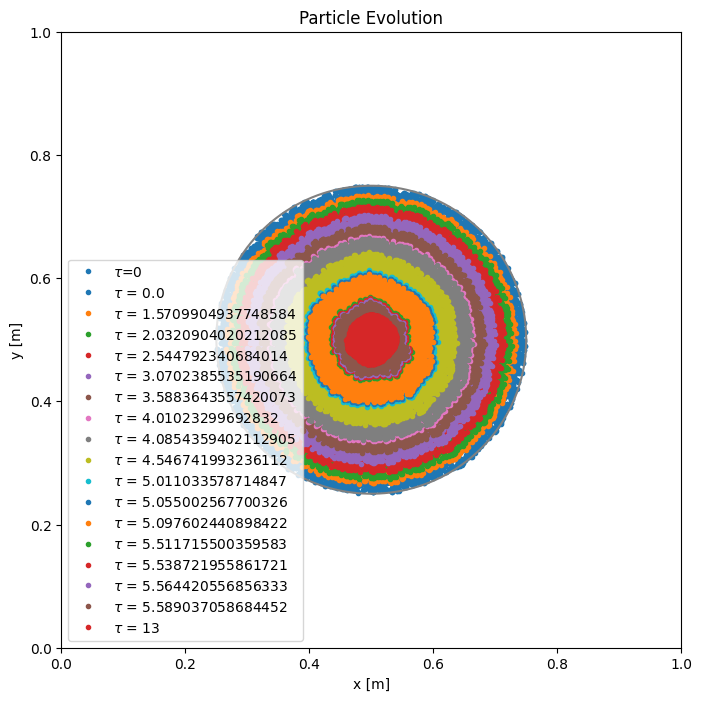

In [13]:
import copy
t_dyn = np.sqrt((pi**2*Rs**3/(4*G*Np)))



plt.figure(figsize=(8,8))
plt.plot(prtMotion[0], prtMotion[1], marker=".", linestyle="None", label=r"$\tau$=0", color="C0")
xSC = np.linspace(-Rs + L/2, Rs+L/2, 500)

def semicircle(x):
    return np.sqrt(Rs**2 - (x - L/2)**2) + L/2

def negSemicircle(x):
    return -np.sqrt(Rs**2 - (x - L/2)**2) + L/2





def evolveParticle(t, s):
    x, y, z = s[0], s[1], s[2]
    vx, vy, vz = s[3], s[4], s[5]
    ax, ay, az = s[6], s[7], s[8]
    fx, fy, fz = vx, vy, vz
    fvx, fvy, fvz =  ax, ay, az
    return np.array([fx, fy, fz, fvx, fvy, fvz])



def leapFrogDKD_3D(f, t0, tf, s0, dt):
    t = np.array([t0])      # t0 is a scalar by default
    s = np.array([s0])

    r0, v0 = np.array([s0[0], s0[1], s0[2]]), np.array([s0[3], s0[4], s0[5]])
    aInit  = np.array([s0[6], s0[7], s0[8]])
    r, v   = np.array([r0]), np.array([v0])
    rd = np.array([[0, 0, 0]])       # Create dummy vector to allow stacking
                                     # rd = r_{drift}

    i = 0
    while t[-1] < tf or i < 100:
        print(aInit)
        h = min(dt, tf-t[-1])
        r_n, v_n = s[-1][:3], s[-1][3:6]  # Current position & velocity

        rd = np.vstack((rd, r_n + v_n*h/2))        # Drift 1

        # insert Poisson Solver here

        s_tmp = np.concatenate((rd[-1], v_n, aInit)) # temporary s vector w/updated vn
        a_nPlusHalf = f(t[-1], s_tmp)[3:]
        v = np.vstack((v, v_n + a_nPlusHalf*h))    # Kick
        r = np.vstack((r, rd[-1] + v[-1]*h/2))

        s_n = np.concatenate((r[-1],v[-1]))
        s = np.vstack((s, s_n))
        t = np.vstack((t, t[-1] + h))

        # insert Poisson Solver here
        i += 1
    return t, s

def getAcc(prt):
    rhoo = createRho(prt)
    rhoo_k = fft.rfftn(rhoo)
    Phii = createPhi(rhoo_k, wk)
    fpm = forcePerMass(Phii)
    acc = interpAcc(prt, fpm)
    return acc


def find_dt(vArr, aArr, lmbda):
    vMax = np.max(vArr)
    aMax = np.max(aArr)
    dt = lmbda*np.min([l/vMax, np.sqrt(l/aMax)])
    if dt != 0:
        return dt
    else:
        return lmbda*max(np.abs(l/vMax), (np.sqrt(l/aMax)))


def evolveSystem(diffEq, t0, tf, prt, dt):
    #print(prt)
    # Initialize values to begin KDK Method
    t = t0
    i = 0
    cCounter = 0
    while t < tf and i < 100:
        # Find desired dt
        vxArr, vyArr, vzArr = prt[3], prt[4], prt[5]
        axArr, ayArr, azArr = prt[6], prt[7], prt[8]
        vArr = np.sqrt(vxArr**2 + vyArr**2 + vzArr**2)
        aArr = np.sqrt(axArr**2 + ayArr**2 + azArr**2)
        dt = find_dt(vArr, aArr, 0.5)

        h = min(dt, tf-t)
        for p in range(Np):
            x, y, z = prt[0, p], prt[1, p], prt[2, p]
            vx, vy, vz = prt[3, p], prt[4, p], prt[5, p]
            ax, ay, az = prt[6, p], prt[7, p], prt[8, p]
            s_n = np.array([x, y, z, vx, vy, vz, ax, ay, az])
            r_n, v_n = s_n[:3], s_n[3:6]
            rd = r_n + v_n*h/2  # Drift 1 is directly calculated, not saved
            #print(f"before = {prt[0, p], prt[1, p], prt[2, p]}")
            prt[0, p], prt[1, p], prt[2, p] = rd[0], rd[1], rd[2]
            #print(f"after = {prt[0, p], prt[1, p], prt[2, p]}")

        prt = getAcc(prt)
        for p in range(Np):
            x, y, z = prt[0, p], prt[1, p], prt[2, p]
            vx, vy, vz = prt[3, p], prt[4, p], prt[5, p]
            ax, ay, az = prt[6, p], prt[7, p], prt[8, p]
            s_tmp = np.array([x, y, z, vx, vy, vz, ax, ay, az])  # Temporary s vector that stores updated acc
            r_n, v_nn = s_tmp[0:3], s_tmp[3:6]
            aPoisson = s_tmp[6:]                 
            v_nPlus1 = v_nn + aPoisson*h/2 # Kick
            prt[3, p] = v_nPlus1[0]
            prt[4, p] = v_nPlus1[1]   # update velocities
            prt[5, p] = v_nPlus1[2]
            
            r_nPlus1 = r_n + v_nPlus1*h/2        # Drift 2
            prt[0, p] = r_nPlus1[0]
            prt[1, p] = r_nPlus1[1]
            prt[2, p] = r_nPlus1[2]
            
        prt = getAcc(prt)

        tau = t/(2*t_dyn)
        print(t/t_dyn)
        

        upsilon = tau/0.5
        eta = int(upsilon)
        if almostEqual(eta - upsilon, 0, 2e-1):
            plt.plot(prt[0], prt[1], marker=".", linestyle="None", label=r"$\tau$ = " + f"{tau}")

        t += h
        i += 1
    return t, prt


prtMotion2 = copy.deepcopy(prtMotion)

vxArrG, vyArrG, vzArrG = prtMotion2[3], prtMotion2[4], prtMotion2[5]
axArrG, ayArrG, azArrG = prtMotion2[6], prtMotion2[7], prtMotion2[8]
vArrG = np.sqrt(vxArrG**2 + vyArrG**2 + vzArrG**2)
aArrG = np.sqrt(axArrG**2 + ayArrG**2 + azArrG**2)
dtInit = find_dt(vArrG, aArrG, 0.5)
#print(dtInit)
print(len(prtMotion2))
tF, finalState = evolveSystem(evolveParticle, 0, 12*t_dyn, prtMotion2, dtInit)



plt.plot(finalState[0], finalState[1], marker=".", linestyle="None", label=f"t = {tF}", color="C3")
plt.plot(xSC, semicircle(xSC), color="grey")
plt.plot(xSC, negSemicircle(xSC), color="grey")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title(f"Particle Evolution")
plt.legend()



Text(0.5, 1.0, 'Particles after 0.008677505738590559 seconds')

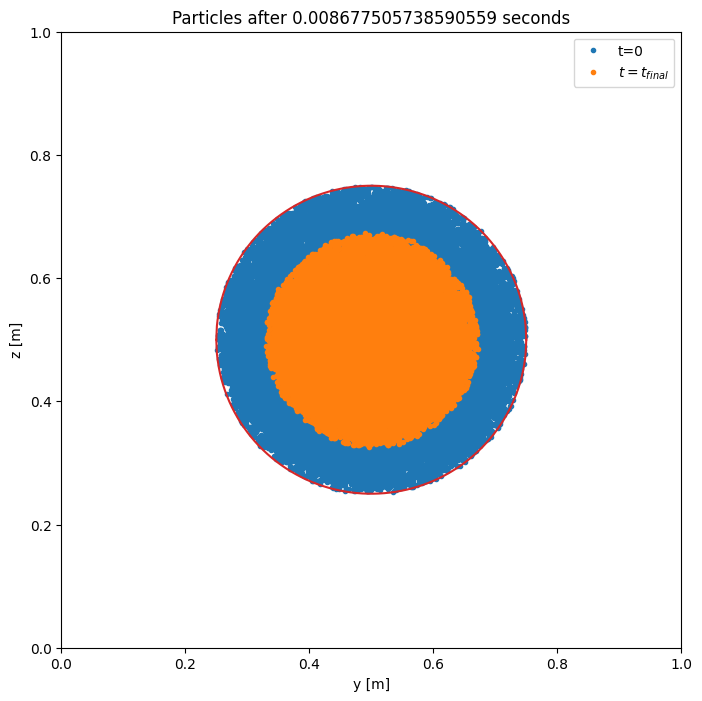

In [44]:
plt.figure(figsize=(8, 8))
plt.plot(prtMotion[1], prtMotion[2], marker=".", color="C0", linestyle="None", label="t=0")
plt.plot(finalState[1], finalState[2], marker=".", linestyle="None", label="$t=t_{final}$", color="C1")
plt.legend()
plt.plot(xSC, semicircle(xSC), color="C3")
plt.plot(xSC, negSemicircle(xSC), color="C3")
plt.xlabel("y [m]")
plt.ylabel("z [m]")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title(f"Particles after {tF} seconds")

## Accelaration Profiles

C:\Users\marco\AppData\Local\Temp\ipykernel_255608\323200252.py:28: RuntimeWarning: divide by zero encountered in scalar divide
  dt = lmbda*np.min([l/vMax, np.sqrt(l/aMax)])


0.0
0.6383635629998248
1.2750422962016055
1.906082039555737
2.528852561669071
3.141980987549717
3.6400569883592415
4.064180804042417
4.4389539826980675
4.778185014473044
5.089584681368028
5.3781812865735485
5.647960660530203
5.901355599952548
6.140477107038133
6.367286010272502
6.583220160045972
6.789456717241939
6.986980506849966
7.176728711484015
7.35925954539876
7.534434223305215
7.7027024601841925
7.864563180664848


Text(0, 0.5, 'f(r)')

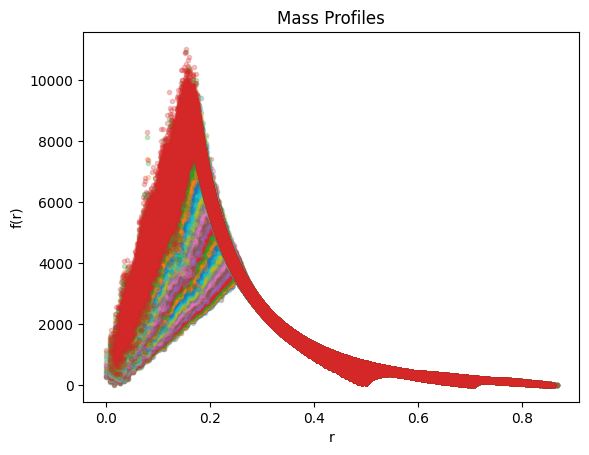

In [23]:
import copy
t_dyn = np.sqrt((pi**2*Rs**3/(4*G*Np)))


xSC = np.linspace(-Rs + L/2, Rs+L/2, 500)

def semicircle(x):
    return np.sqrt(Rs**2 - (x - L/2)**2) + L/2

def negSemicircle(x):
    return -np.sqrt(Rs**2 - (x - L/2)**2) + L/2





def getFpm(prt):
    rhoo = createRho(prt)
    rhoo_k = fft.rfftn(rhoo)
    Phii = createPhi(rhoo_k, wk)
    fpm = forcePerMass(Phii)
    return fpm


def find_dt(vArr, aArr, lmbda):
    vMax = np.max(vArr)
    aMax = np.max(aArr)
    dt = lmbda*np.min([l/vMax, np.sqrt(l/aMax)])
    if dt != 0:
        return dt
    else:
        return lmbda*max(np.abs(l/vMax), (np.sqrt(l/aMax)))


def evolveSystem2(diffEq, t0, tf, prt, dt):
    #print(prt)
    # Initialize values to begin KDK Method
    t = t0
    i = 0
    cCounter = 0
    while t < tf and i < 200:
        # Find desired dt
        vxArr, vyArr, vzArr = prt[3], prt[4], prt[5]
        axArr, ayArr, azArr = prt[6], prt[7], prt[8]
        vArr = np.sqrt(vxArr**2 + vyArr**2 + vzArr**2)
        aArr = np.sqrt(axArr**2 + ayArr**2 + azArr**2)
        dt = find_dt(vArr, aArr, 0.5)

        h = min(dt, tf-t)
        for p in range(Np):
            x, y, z = prt[0, p], prt[1, p], prt[2, p]
            vx, vy, vz = prt[3, p], prt[4, p], prt[5, p]
            ax, ay, az = prt[6, p], prt[7, p], prt[8, p]
            s_n = np.array([x, y, z, vx, vy, vz, ax, ay, az])
            r_n, v_n = s_n[:3], s_n[3:6]
            rd = r_n + v_n*h/2  # Drift 1 is directly calculated, not saved
            #print(f"before = {prt[0, p], prt[1, p], prt[2, p]}")
            prt[0, p], prt[1, p], prt[2, p] = rd[0], rd[1], rd[2]
            #print(f"after = {prt[0, p], prt[1, p], prt[2, p]}")

        prt = getAcc(prt)
        for p in range(Np):
            x, y, z = prt[0, p], prt[1, p], prt[2, p]
            vx, vy, vz = prt[3, p], prt[4, p], prt[5, p]
            ax, ay, az = prt[6, p], prt[7, p], prt[8, p]
            s_tmp = np.array([x, y, z, vx, vy, vz, ax, ay, az])  # Temporary s vector that stores updated acc
            r_n, v_nn = s_tmp[0:3], s_tmp[3:6]
            aPoisson = s_tmp[6:]                 
            v_nPlus1 = v_nn + aPoisson*h/2 # Kick
            prt[3, p] = v_nPlus1[0]
            prt[4, p] = v_nPlus1[1]   # update velocities
            prt[5, p] = v_nPlus1[2]
            
            r_nPlus1 = r_n + v_nPlus1*h/2        # Drift 2
            prt[0, p] = r_nPlus1[0]
            prt[1, p] = r_nPlus1[1]
            prt[2, p] = r_nPlus1[2]
            
        prt = getAcc(prt)

        fpm = getFpm(prt)
        rVals, frVals = get_fr(fpm, L/2, L/2, L/2)
        plt.plot(rVals, frVals, marker=".", linestyle="None", alpha=0.25, label=r"$tau = $" + f"{t/t_dyn}")
        print(t/t_dyn)
        t += h
        i += 1
    return t, prt


prtMotion3 = copy.deepcopy(prtMotion)

vxArrG, vyArrG, vzArrG = prtMotion2[3], prtMotion2[4], prtMotion2[5]
axArrG, ayArrG, azArrG = prtMotion2[6], prtMotion2[7], prtMotion2[8]
vArrG = np.sqrt(vxArrG**2 + vyArrG**2 + vzArrG**2)
aArrG = np.sqrt(axArrG**2 + ayArrG**2 + azArrG**2)
dtInit = find_dt(vArrG, aArrG, 0.5)
tF, finalState = evolveSystem2(evolveParticle, 0, 8*t_dyn, prtMotion3, dtInit)


plt.title(f"Accelaration profiles")
plt.xlabel("r")
plt.ylabel("f(r)")


### Note, tau values were omitted for visual clarity, they are the same as above

Above, we can see Poisson's (or Gauss's Law) equation at work: outside the radius of the body, it is an inverse square (i.e. acts like a point of equivalent mass). Inside mass, it is linear, and the radius of this mass is getting closer and closer to 0

## Discussion

In my results, the mass stops shrinking at approximately t = 13$\tau$, much longer than the anticipated; if my model is correct this could likely be due to the the random orientation of significant masses escaping the body. This can render the density of the mass non-uniform and contribute to time delays

If my model is not correct, then either way it is likely that it takes longer than than $t_{dyn}$ as there are likely other forces contributing to the n-body, such as pressure gradients, magnetic forces, etc